In [441]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from bertopic import BERTopic
os.chdir('../scripts')
from utils import *
os.chdir('../notebooks')
from sklearn.linear_model import LinearRegression
from scipy.stats import entropy

In [442]:
def get_transformer_features(models, loss):
    X_train, X_validation, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    for m in models:
        train, validation, test = read_features(loss, m)
        X_train[m] = train 
        X_validation[m] = validation
        X_test[m] = test

    return X_train, X_validation, X_test

def read_features(loss, model_name, clip=True):
    df_train = pd.read_csv(f'..\\models\\{loss}\\end2end\\{model_name}\\train_res.csv')
    df_validation = pd.read_csv(f'..\\models\\{loss}\\end2end\\{model_name}\\validation_res.csv')
    df_test = pd.read_csv(f'..\\models\\{loss}\\end2end\\{model_name}\\test_res.csv')

    if clip:
        df_train.clip(0, 5, inplace=True)
        df_validation.clip(0, 5, inplace=True)
        df_test.clip(0, 5, inplace=True)

    return df_train, df_validation, df_test

In [443]:
dataset = load_dataset_from_huggingface(DATASET_PATH, CONFIG_NAME, '../dataset/stsb')

Found cached dataset glue (C:/Users/Ivan/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [444]:
df_test = dataset['test'].to_pandas()
train_transformer_features, _, test_transformer_features = get_transformer_features(
    ['bert-large-cased', 'microsoft-deberta-v3-large','roberta-large'], 'mse'
)

train_handmade_features = pd.read_csv(f'../dataset/stsb/train_features.csv')
test_handmade_features = pd.read_csv(f'../dataset/stsb/test_features.csv')
X_test = pd.concat((test_transformer_features, test_handmade_features), axis=1)

display(X_test.head())

,bert-large-cased,microsoft-deberta-v3-large,roberta-large,num_chars_s1,num_chars_s2,num_tokens_s1,num_tokens_s2,num_stopwords_s1,num_stopwords_s2,num_token_overlap,num_lemma_overlap,num_nouns_s1,num_nouns_s2,num_verbs_s1,num_verbs_s2,num_adj_s1,num_adj_s2
0,2.452218,3.348965,3.114362,27,28,7,7,3,3,6,6,2,2,1,1,0,0
1,4.304604,4.088571,3.953851,40,48,10,11,4,5,8,9,4,4,1,1,0,0
2,4.884091,5.000000,4.869068,45,39,9,8,4,3,5,6,3,3,1,1,0,0
3,4.674862,4.594983,4.829213,31,28,8,7,4,3,6,5,2,2,1,1,0,0
4,1.992724,1.743071,1.921305,24,28,7,7,3,3,6,5,2,2,1,1,0,0


In [445]:
best_mse_model = pickle.load(open('best_model_lgbm_mse_3_not_stratified.pkl', 'rb'))
best_mse_model

LGBMRegressor(boosting_type='goss', max_depth=3, num_leaves=20, random_state=42)

In [446]:
test_preds = pd.DataFrame(best_mse_model.predict(X_test), columns=['preds'])
compute_metrics_(test_preds.to_numpy().reshape(-1), df_test['label'].to_numpy().reshape(-1))

{'pearson_r': 0.9095565639387426, 'spearman_r': 0.9057195975913954}

In [447]:
df_test = pd.concat((df_test, test_preds), axis=1)
df_test['diff'] = np.abs(df_test['label'] - df_test['preds'])
df_test.sort_values('diff', ascending=False, inplace=True)

with pd.option_context('display.max_colwidth', 500):
    display(df_test.head())

,sentence1,sentence2,idx,label,preds,diff
770,The answer to both questions is: Yes.,To directly answer the two questions in your title.,770,0.0,2.592846,2.592846
745,It's also a matter of taste.,It's definitely just a matter of preference.,745,5.0,2.493077,2.506923
305,Three sheep on a dirt road viewed from a passenger vehicle.,Three sheep on a dirt road shot from a car.,305,2.2,4.343828,2.143828
839,I had the same problem as you.,I have exactly the same problem.,839,5.0,2.899427,2.100573
687,No it does not affect your ratings.,No it is not.,687,0.0,2.058813,2.058813


[0.547 0.532 0.465 0.388 0.472 0.602]


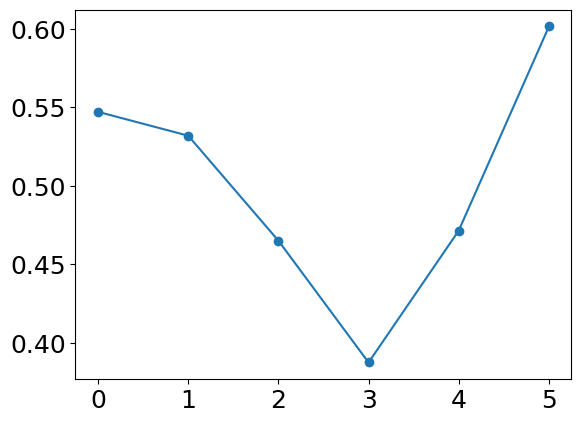

In [448]:
def get_diff_label_list(df_test):
    diff_label_df = df_test[['diff', 'label']]
    diff_label_df.sort_values('label', ascending=True, inplace=True)
    diff_label_df.reset_index(drop=True, inplace=True)

    bounds = [-0.001, 0.5, 1.5, 2.5, 3.5, 4.5, 5]
    df_bins = []
    for i in range(len(bounds[:-1])):
        df_bins.append(
            diff_label_df[(diff_label_df['label'] > bounds[i]) & (diff_label_df['label'] <= bounds[i+1])]
        )
        
    x = [i.mean()['diff'] for i in df_bins]
    return x

x = get_diff_label_list(df_test)
plt.plot(x, 'o-')
plt.savefig('../figures/label_diff_mse')
print(np.round(x, decimals=3))

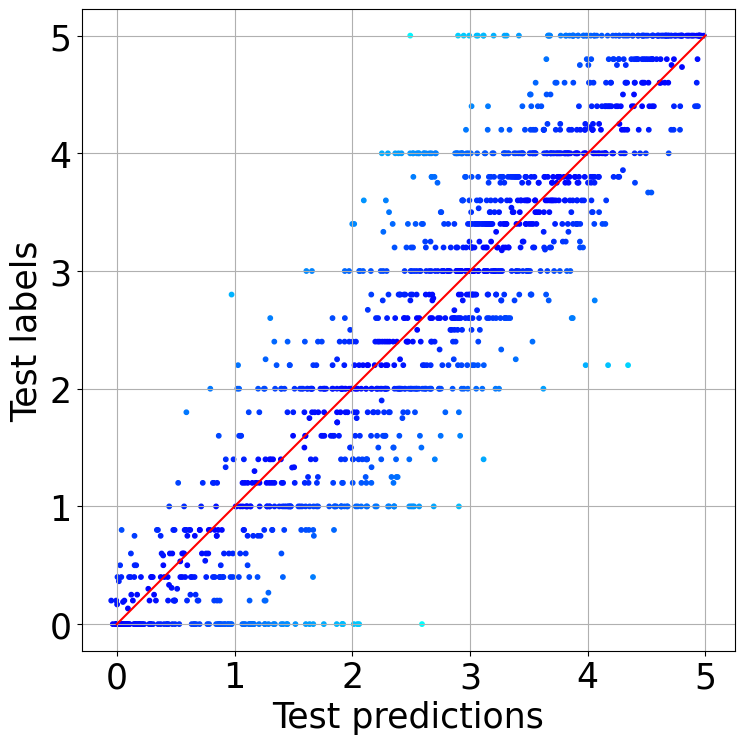

In [450]:
def scatterplot_preds_labels(df_test, save=None):
    plt.figure(figsize=(8, 8))
    c = np.array([
        np.zeros(shape=df_test.shape[0]),
        (df_test['diff'] - df_test['diff'].min())/(df_test['diff'].max() - df_test['diff'].min()),
        np.repeat(1, df_test.shape[0]),
    ]).T

    plt.scatter(df_test['preds'], df_test['label'], s=10, c=c)
    plt.plot([0, 5], [0, 5], c='r')
    plt.grid()
    plt.axis('equal')
    plt.rcParams.update({'font.size': 25})
    plt.ylabel('Test labels')
    plt.xlabel('Test predictions')
    if save is not None:
        plt.tight_layout()
        plt.savefig(f'../figures/preds_vs_labels_{save}.png', bbox_inches='tight')
    plt.show()
scatterplot_preds_labels(df_test, save='mse')

* Homogeneous variance

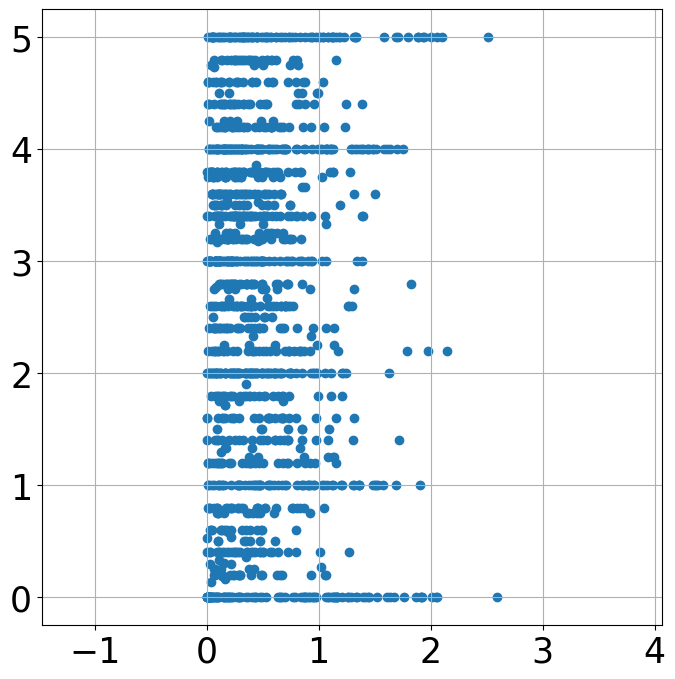

In [451]:
def scatterplot_label_diff(df_test):
    plt.figure(figsize=(8, 8))
    plt.scatter(df_test['diff'], df_test['label'])
    plt.rcParams.update({'font.size': 10})
    plt.grid()
    plt.axis('equal')
    plt.show()
    
scatterplot_label_diff(df_test)

In [452]:
nlp = spacy.load("en_core_web_lg")
df_test['sent1_stopwords'] = df_test['sentence1'].apply(lambda x: len([i.lemma_ in nlp.Defaults.stop_words for i in nlp(x)]))
df_test['sent2_stopwords'] = df_test['sentence2'].apply(lambda x: len([i.lemma_ in nlp.Defaults.stop_words for i in nlp(x)]))


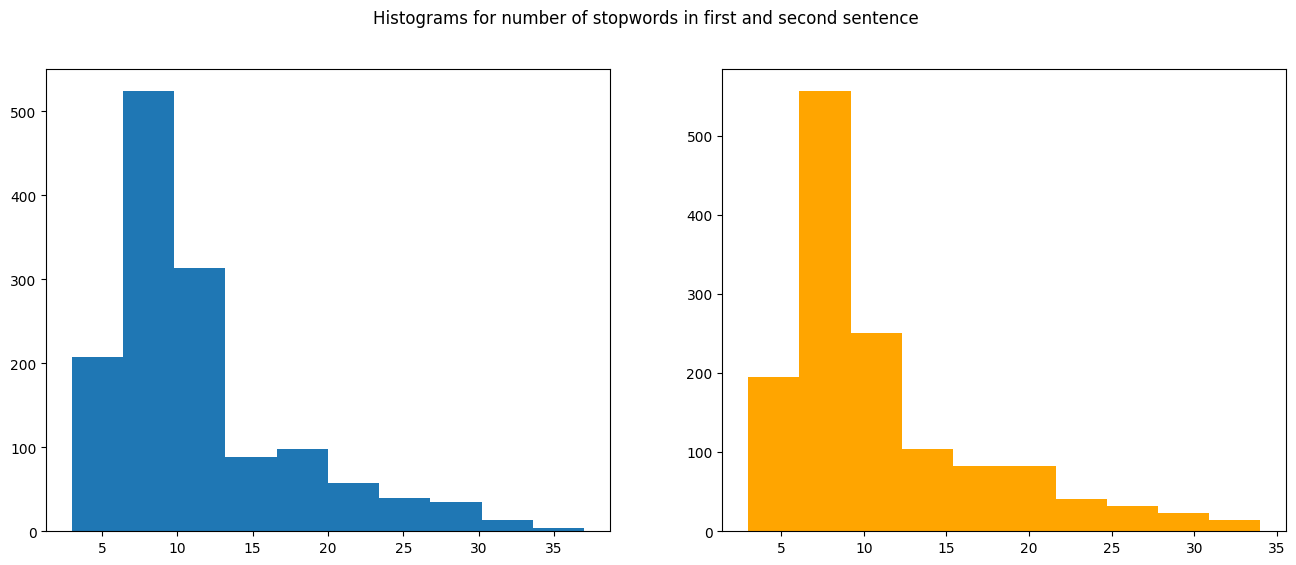

In [453]:
def plot_stopword_histograms(df_test):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].hist(df_test['sent1_stopwords'])
    axs[1].hist(df_test['sent2_stopwords'], color='orange')
    plt.suptitle('Histograms for number of stopwords in first and second sentence')
    plt.show()
    
plot_stopword_histograms(df_test)

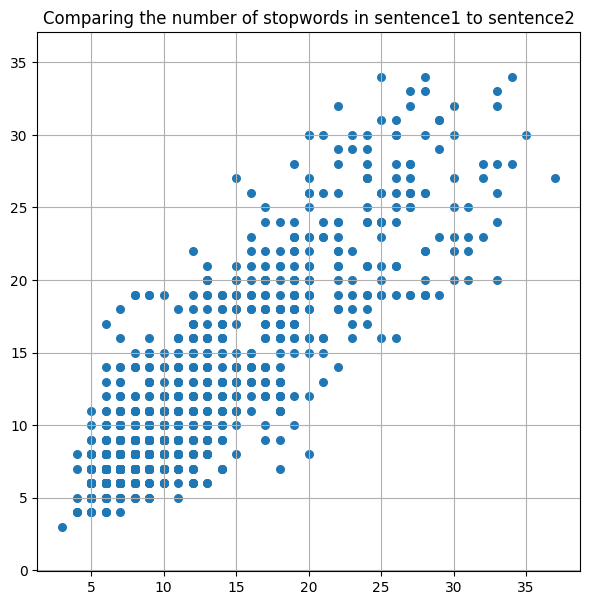

In [454]:
def plot_stopwords(df_test):
    model = LinearRegression().fit(
        df_test['sent1_stopwords'].values.reshape(-1, 1), 
        df_test['sent2_stopwords'].values.reshape(-1, 1)
    )

    x = np.array([[0, 40]]).T
    plt.figure(figsize=(7, 7))
    plt.scatter(df_test['sent1_stopwords'], df_test['sent2_stopwords'], s=30)
    plt.axis('equal')
    plt.title('Comparing the number of stopwords in sentence1 to sentence2')
    plt.grid()
    plt.show()
    compute_metrics_(
        df_test['sent1_stopwords'].to_numpy().reshape(-1), df_test['sent2_stopwords'].to_numpy().reshape(-1)
    )
    
plot_stopwords(df_test)

* Highly correlated number of stopwords in sentence pairs

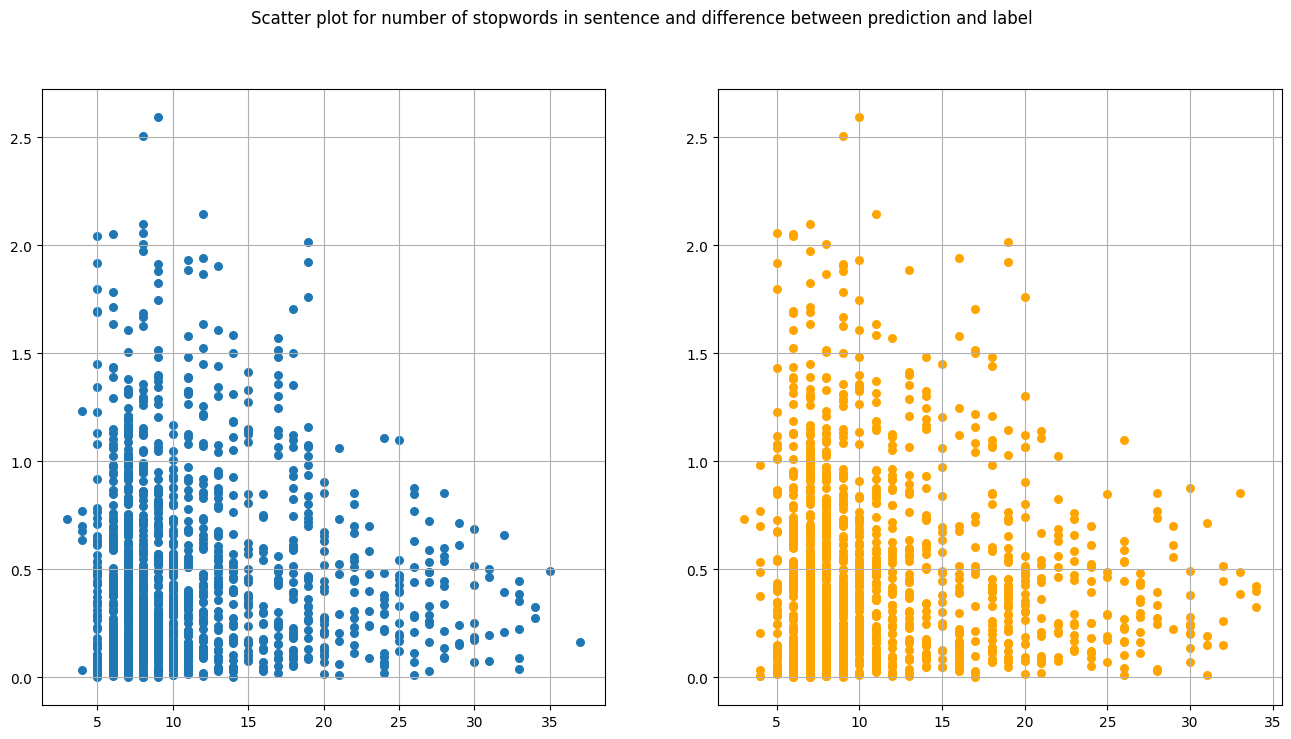

In [455]:
def scatterplot_stopwords(df_test):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    axs[0].scatter(df_test['sent1_stopwords'], df_test['diff'], s=30)
    #sns.kdeplot(data=df_test, x="sent1_stopwords", y="diff", ax=axs[0])
    axs[0].grid()
    axs[1].scatter(df_test['sent2_stopwords'], df_test['diff'], s=30, c='orange')
    #sns.kdeplot(data=df_test, x="sent1_stopwords", y="diff", ax=axs[1], color='orange')
    axs[1].grid()
    plt.suptitle('Scatter plot for number of stopwords in sentence and difference between prediction and label')
    plt.show()
    
scatterplot_stopwords(df_test)

* Variance of difference between prediction and label is inversely proportionate to number of stopwords

In [456]:
threshold = 1

df_test_severe = df_test[df_test['diff'] > threshold]
df_test_not_severe = df_test[df_test['diff'] <= threshold]

In [457]:
incorrect_ends = df_test_severe[
    (df_test_severe['label'] == 5) | (df_test_severe['label'] == 0)
][['sentence1', 'sentence2', 'label', 'preds', 'sent1_stopwords', 'sent2_stopwords', 'diff']]
incorrect_ends.head()

,sentence1,sentence2,label,preds,sent1_stopwords,sent2_stopwords,diff
770,The answer to both questions is: Yes.,To directly answer the two questions in your t...,0.0,2.592846,9,10,2.592846
745,It's also a matter of taste.,It's definitely just a matter of preference.,5.0,2.493077,8,9,2.506923
839,I had the same problem as you.,I have exactly the same problem.,5.0,2.899427,8,7,2.100573
687,No it does not affect your ratings.,No it is not.,0.0,2.058813,8,5,2.058813
668,Take a look at these:,Take a look at this:,5.0,2.946972,6,6,2.053028


In [458]:
correct_ends = df_test_not_severe[
    (df_test_not_severe['label'] == 5) | (df_test_not_severe['label'] == 0)
][['sentence1', 'sentence2', 'label', 'preds', 'sent1_stopwords', 'sent2_stopwords', 'diff']]
correct_ends.head()

,sentence1,sentence2,label,preds,sent1_stopwords,sent2_stopwords,diff
715,You PROBABLY don't have any chance at the moment.,"Saying ""thanks, I don't have any questions at ...",0.0,0.975920,11,15,0.975920
783,You answered your own question.,You pretty much answered your own question.,5.0,4.025964,6,8,0.974036
568,Adding aspirin to the water could kill the plant.,Men are trying to remove oil from a body of wa...,0.0,0.964843,10,12,0.964843
762,You don't need any visa.,You don't need sauce at all.,0.0,0.946640,7,8,0.946640
652,It's not a good idea.,It's a good question.,0.0,0.945036,7,6,0.945036


In [459]:
lemma = lambda x: [i.lemma_ for i in nlp(x)]
lemma_no_stopw = lambda x: [i.lemma_ for i in nlp(x) if i.lemma_ not in nlp.Defaults.stop_words]
lemma_percentage = lambda x: len(set(lemma(x['sentence2'])).intersection(set(lemma(x['sentence1'])))) / len(set(lemma(x['sentence2'])).union(set(lemma(x['sentence1']))))
lemma_percentage_no_stopw = lambda x: len(set(lemma_no_stopw(x['sentence2'])).intersection(set(lemma_no_stopw(x['sentence1'])))) / len(set(lemma_no_stopw(x['sentence2'])).union(set(lemma_no_stopw(x['sentence1']))))

incorrect_ends['lemma_perc'] = incorrect_ends.apply(
    lambda x: lemma_percentage(x), axis=1
)
incorrect_ends['lemma_perc_wo_stopword'] = incorrect_ends.apply(
    lambda x: lemma_percentage_no_stopw(x), axis=1
)

correct_ends['lemma_perc'] = correct_ends.apply(
    lambda x: lemma_percentage(x), axis=1
)
correct_ends['lemma_perc_wo_stopword'] = correct_ends.apply(
    lambda x: lemma_percentage_no_stopw(x), axis=1
)

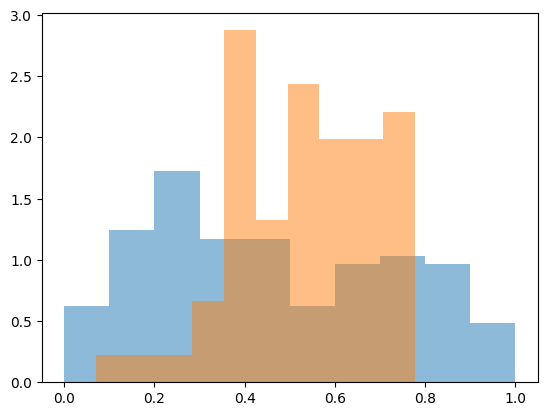

In [460]:
plt.hist(correct_ends['lemma_perc'], alpha=0.5, density=True)
plt.hist(incorrect_ends['lemma_perc'], alpha=0.5, density=True)
plt.show()

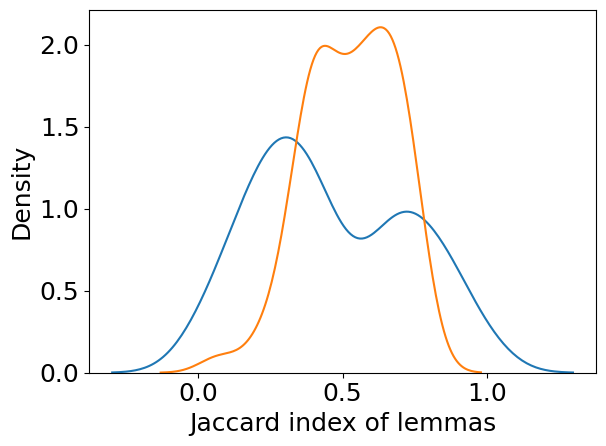

In [462]:
sns.kdeplot(correct_ends, x='lemma_perc')
sns.kdeplot(incorrect_ends, x='lemma_perc')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Jaccard index of lemmas")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_for_corr_incorr_mse.png", bbox_inches='tight')
plt.show()

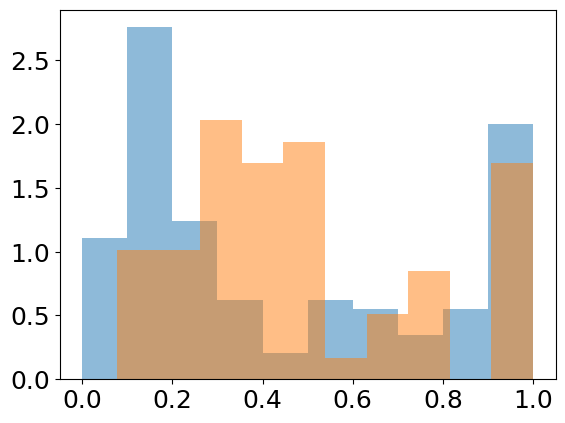

In [463]:
plt.hist(correct_ends['lemma_perc_wo_stopword'], alpha=0.5, density=True)
plt.hist(incorrect_ends['lemma_perc_wo_stopword'], alpha=0.5, density=True)
plt.show()

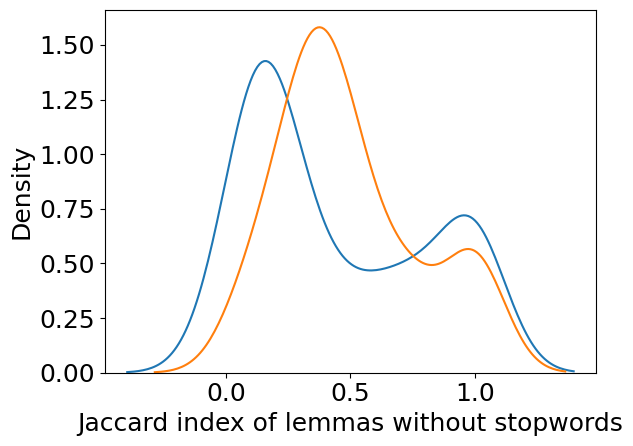

In [465]:
sns.kdeplot(correct_ends, x='lemma_perc_wo_stopword')
sns.kdeplot(incorrect_ends, x='lemma_perc_wo_stopword')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Jaccard index of lemmas without stopwords")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_wo_stopword_for_corr_incorr_mse.png", bbox_inches='tight')
plt.show()

* Percentage of lemma set overlaps says a lot about how hard an example is for the model:
    1. the lemma set overlaps in incorrect pairs have one mode, which is around 50% overlap
    2. the lemma set overlaps in correct pairs have two mdoes, around 20% overlap and 90% overlap
    3. removing stopwords makes the histograms more similar to each other

In [466]:
lemma_percentage_no_stopw_same = lambda x, sent: len(lemma_no_stopw(x[sent])) / len(lemma(x[sent]))

incorrect_ends['lemma_perc_wo_stopword_over_sent1'] = incorrect_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence1'), axis=1
)
incorrect_ends['lemma_perc_wo_stopword_over_sent2'] = incorrect_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence2'), axis=1
)

correct_ends['lemma_perc_wo_stopword_over_sent1'] = correct_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence1'), axis=1
)
correct_ends['lemma_perc_wo_stopword_over_sent2'] = correct_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence2'), axis=1
)

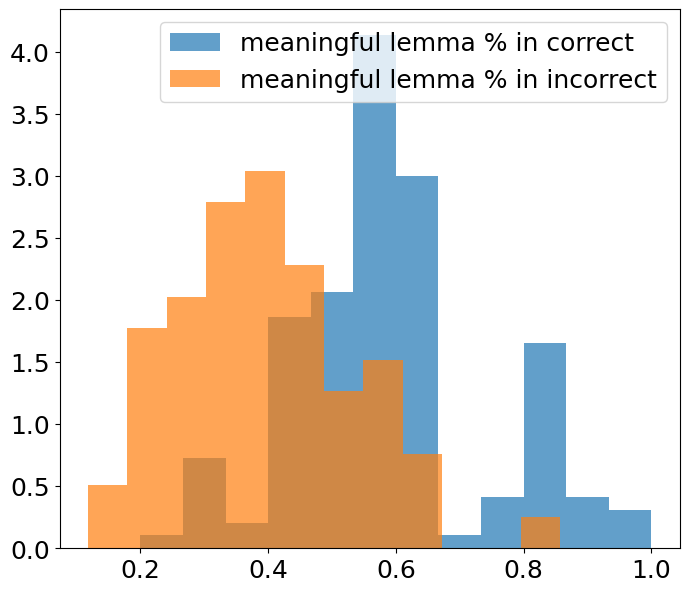

In [467]:
plt.figure(figsize=(8,7))
plt.hist(correct_ends['lemma_perc_wo_stopword_over_sent1'], bins=12, alpha=.7, label='meaningful lemma % in correct', density=True)
plt.hist(incorrect_ends['lemma_perc_wo_stopword_over_sent1'], bins=12, alpha=.7, label='meaningful lemma % in incorrect', density=True)
plt.legend()
plt.show()

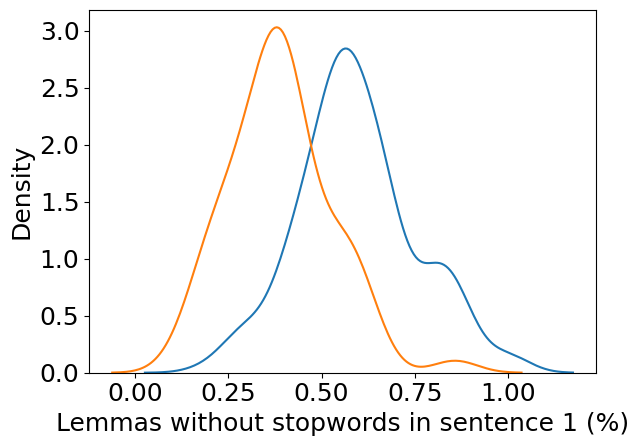

In [471]:
sns.kdeplot(correct_ends, x='lemma_perc_wo_stopword_over_sent1')
sns.kdeplot(incorrect_ends, x='lemma_perc_wo_stopword_over_sent1')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Lemmas without stopwords in sentence 1 (%)")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_wo_stopword_over_sent1_for_corr_incorr_mse.png", bbox_inches='tight')
plt.show()

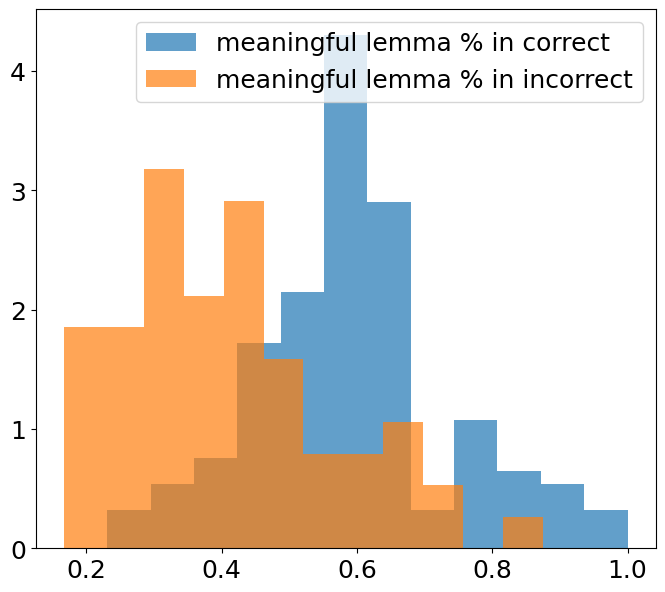

In [472]:
plt.figure(figsize=(8,7))
plt.hist(correct_ends['lemma_perc_wo_stopword_over_sent2'], bins=12, alpha=.7, label='meaningful lemma % in correct', density=True)
plt.hist(incorrect_ends['lemma_perc_wo_stopword_over_sent2'], bins=12, alpha=.7, label='meaningful lemma % in incorrect', density=True)
plt.legend()
plt.show()

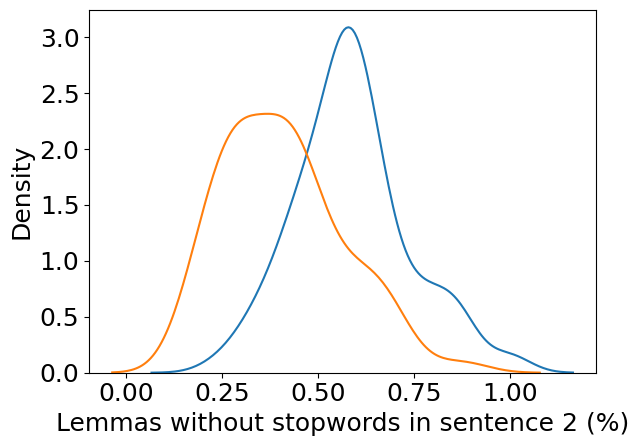

In [474]:
sns.kdeplot(correct_ends, x='lemma_perc_wo_stopword_over_sent2')
sns.kdeplot(incorrect_ends, x='lemma_perc_wo_stopword_over_sent2')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Lemmas without stopwords in sentence 2 (%)")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_wo_stopword_over_sent2_for_corr_incorr_mse.png", bbox_inches='tight')
plt.show()

* Percentage of lemmas that aren't stopwords in the correct pairs has a higher mean than in the incorrect pairs
* This could mean that, intuitively, the predictions of this model will be more correct if the sentences have a higher percentage of meaningful lemmas 

In [475]:
correct_ends['sentence_concat'] = correct_ends['sentence1'] + ' ' + correct_ends['sentence2']
incorrect_ends['sentence_concat'] = incorrect_ends['sentence1'] + ' ' + incorrect_ends['sentence2']

In [476]:
from pandas import option_context
with option_context('display.max_colwidth', 500):
    display(correct_ends.sort_values('diff', ascending=True)[['sentence1', 'sentence2', 'diff', 'preds', 'label']].head())

,sentence1,sentence2,diff,preds,label
426,A boy in red jumping into a sandbox.,A dog swimming in a pond,0.000705,-0.000705,0.0
61,A train is moving.,A man is doing yoga.,0.003602,-0.003602,0.0
445,A brown and white dog is running across a brown field.,A person hanging from a rocky cliff.,0.004338,0.004338,0.0
377,A small camouflaged airplane parked in the grass.,A small dog wearing a pink shirt tied to a railing.,0.004494,-0.004494,0.0
241,A chimp is kicking a target.,A woman is putting oil into a skillet.,0.005119,-0.005119,0.0


In [477]:
with option_context('display.max_colwidth', 500):
    display(incorrect_ends.sort_values('diff', ascending=False)[['sentence1', 'sentence2', 'diff', 'preds', 'label']].head())

,sentence1,sentence2,diff,preds,label
770,The answer to both questions is: Yes.,To directly answer the two questions in your title.,2.592846,2.592846,0.0
745,It's also a matter of taste.,It's definitely just a matter of preference.,2.506923,2.493077,5.0
839,I had the same problem as you.,I have exactly the same problem.,2.100573,2.899427,5.0
687,No it does not affect your ratings.,No it is not.,2.058813,2.058813,0.0
668,Take a look at these:,Take a look at this:,2.053028,2.946972,5.0


In [369]:
hf_df = load_dataset_from_huggingface('glue', 'stsb', '../dataset/stsb')
best_ce_model = pickle.load(open('best_model_lgbm_cross_entropy_3_not_stratified.pkl', 'rb'))
best_ce_model

df_train = hf_df['train'].to_pandas()
X_train = pd.concat((train_transformer_features, train_handmade_features), axis=1)
train_preds = pd.DataFrame(best_ce_model.predict(X_train), columns=['preds'])

df_train['preds'] = train_preds['preds']
df_train['diff'] = np.abs(df_train['preds'] - df_train['label'])

compute_metrics_(train_preds.to_numpy().reshape(-1), df_train['label'].to_numpy().reshape(-1))

Found cached dataset glue (C:/Users/Ivan/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

{'pearson_r': 0.7172962591757922, 'spearman_r': 0.6209729428293106}

In [249]:
def find_count_lemmas(df):
    lemmas = {}
    for j, data in tqdm((df[['sentence1', 'sentence2']]).iterrows()):
        s = data['sentence1'] + ' ' + data['sentence2']
        for i in nlp(s):
            if i.lemma_ not in nlp.Defaults.stop_words and not i.is_punct:
                if i.lemma_ not in lemmas.keys():
                    lemmas[i.lemma_] = 1
                else:
                    lemmas[i.lemma_] = lemmas[i.lemma_] + 1

    lemmas = dict(sorted(lemmas.items(), key=lambda x: x[1]))
    print(len(lemmas))
    return lemmas

def find_in_test_not_train(train_lemmas, test_lemmas, max_occurence=5):
    in_test_not_train = {}
    for k1, k2 in zip(train_lemmas.keys(), test_lemmas.keys()):
        if k2 not in train_lemmas.keys() or train_lemmas[k2] < max_occurence:
            if k2 not in in_test_not_train.keys():
                in_test_not_train[k2] = 1
            else:
                in_test_not_train[k2] = in_test_not_train[k2] + 1
    print(len(in_test_not_train))
    return in_test_not_train

def find_sents_with_lemmas(lemmas, df_test):
    sents_with_in_test_not_train = set()
    sents_with_in_test_in_train = set()
    for j, data in tqdm((df_test[['sentence1', 'sentence2']]).iterrows()):
        s = data['sentence1'] + ' ' + data['sentence2']
        for i in nlp(s):
            if i.lemma_ in lemmas:
                sents_with_in_test_not_train.add(j)
            else:
                sents_with_in_test_in_train.add(j)

    print(len(sents_with_in_test_not_train), len(sents_with_in_test_in_train))
    return sents_with_in_test_not_train, sents_with_in_test_in_train

def plot_lemmas(df1, df2, s='diff'):
    sns.kdeplot(df1[s])
    sns.kdeplot(df2[s], color='C1')
    plt.show()

5749it [00:31, 182.38it/s]


10780


1379it [00:07, 192.34it/s]


4096
1091


1379it [00:06, 207.05it/s]


548 1379


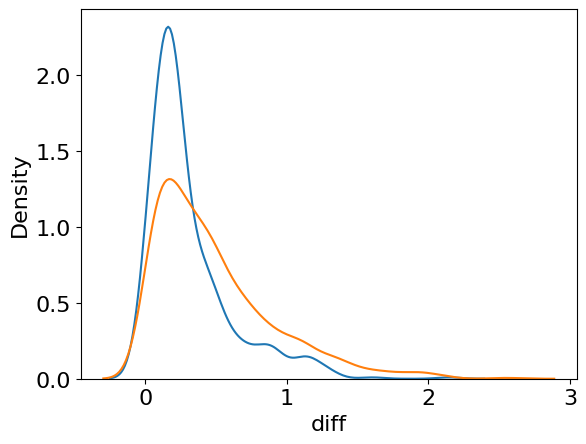

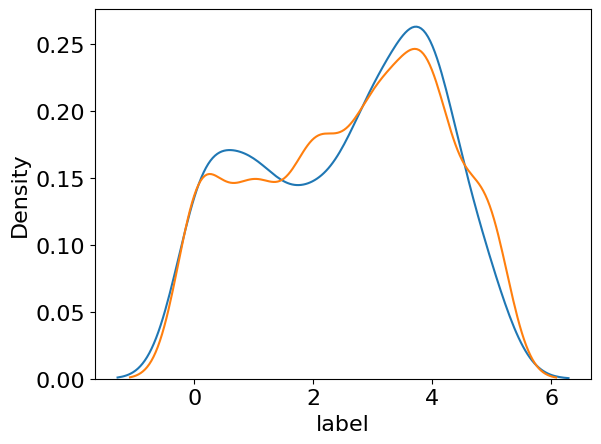

In [250]:
train_lemmas = find_count_lemmas(df_train)
test_lemmas = find_count_lemmas(df_test)

in_test_not_train = find_in_test_not_train(train_lemmas, test_lemmas, max_occurence=0)
sents_with_in_test_not_train, sents_with_in_test_in_train = find_sents_with_lemmas(in_test_not_train, df_test)

df_out_of_train_lemma = df_test.iloc[list(sents_with_in_test_not_train)]
df_in_train_lemma = df_test.iloc[list(sents_with_in_test_in_train)]

plot_lemmas(df_out_of_train_lemma, df_in_train_lemma)
plot_lemmas(df_out_of_train_lemma, df_in_train_lemma, 'label')

3431


1379it [00:07, 178.71it/s]


554 1379


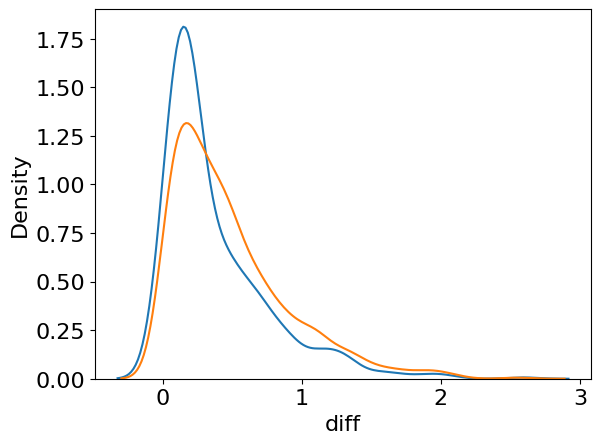

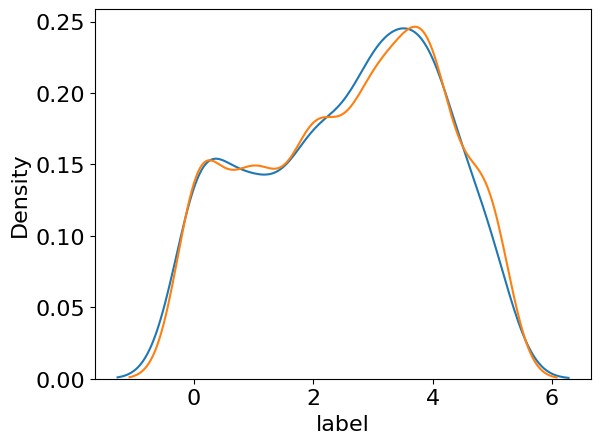

In [251]:
in_test_not_train = find_in_test_not_train(train_lemmas, test_lemmas, max_occurence=20)
in_test_not_train = dict(
    np.array(list(in_test_not_train.items()))[np.random.choice(len(in_test_not_train), 548, replace=False)]
)
sents_with_in_test_not_train, sents_with_in_test_in_train = find_sents_with_lemmas(in_test_not_train, df_test)

df_out_of_train_lemma = df_test.iloc[list(sents_with_in_test_not_train)]
df_in_train_lemma = df_test.iloc[list(sents_with_in_test_in_train)]

plot_lemmas(df_out_of_train_lemma, df_in_train_lemma)
plot_lemmas(df_out_of_train_lemma, df_in_train_lemma, 'label')

3807


1379it [00:08, 167.91it/s]


638 1379


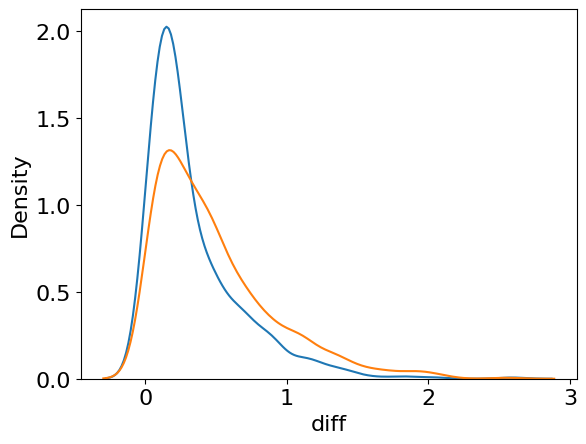

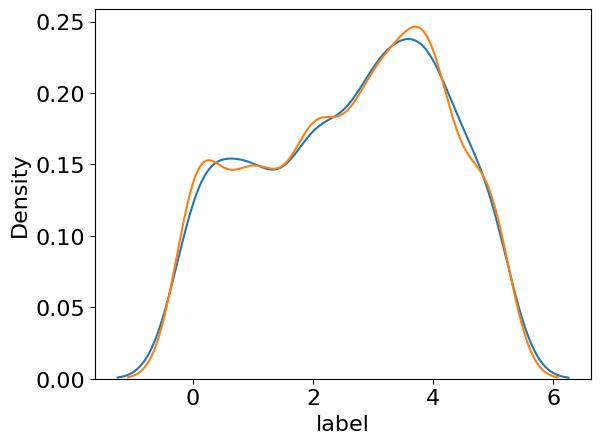

In [252]:
in_test_not_train = find_in_test_not_train(train_lemmas, test_lemmas, max_occurence=40)
in_test_not_train = dict(
    np.array(list(in_test_not_train.items()))[np.random.choice(len(in_test_not_train), 548, replace=False)]
)
sents_with_in_test_not_train, sents_with_in_test_in_train = find_sents_with_lemmas(in_test_not_train, df_test)

df_out_of_train_lemma = df_test.iloc[list(sents_with_in_test_not_train)]
df_in_train_lemma = df_test.iloc[list(sents_with_in_test_in_train)]

plot_lemmas(df_out_of_train_lemma, df_in_train_lemma)
plot_lemmas(df_out_of_train_lemma, df_in_train_lemma, 'label')

3933


1379it [00:07, 181.37it/s]

641 1379


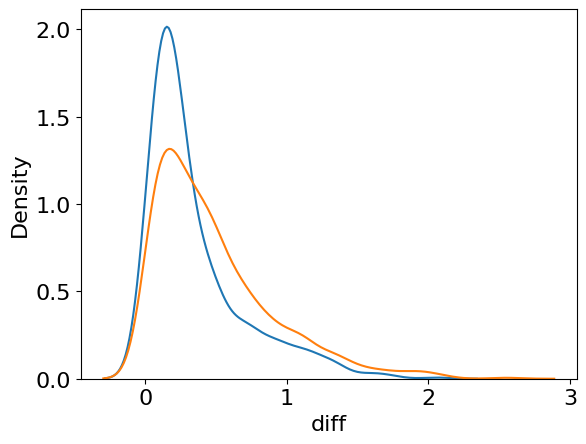

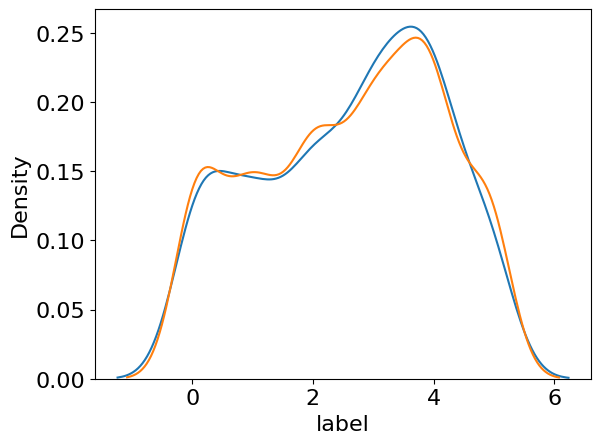

In [253]:
in_test_not_train = find_in_test_not_train(train_lemmas, test_lemmas, max_occurence=60)
in_test_not_train = dict(
    np.array(list(in_test_not_train.items()))[np.random.choice(len(in_test_not_train), 548, replace=False)]
)
sents_with_in_test_not_train, sents_with_in_test_in_train = find_sents_with_lemmas(in_test_not_train, df_test)

df_out_of_train_lemma = df_test.iloc[list(sents_with_in_test_not_train)]
df_in_train_lemma = df_test.iloc[list(sents_with_in_test_in_train)]

plot_lemmas(df_out_of_train_lemma, df_in_train_lemma)
plot_lemmas(df_out_of_train_lemma, df_in_train_lemma, 'label')

In [254]:
in_test_not_train = find_in_test_not_train(train_lemmas, test_lemmas, max_occurence=0)
in_test_not_train = dict(
    np.array(list(in_test_not_train.items()))[np.random.choice(len(in_test_not_train), 548, replace=False)]
)
sents_with_in_test_not_train, sents_with_in_test_in_train = find_sents_with_lemmas(in_test_not_train, df_test)

df_out_of_train_lemma = df_test.iloc[list(sents_with_in_test_not_train)]

1091


1379it [00:08, 155.29it/s]

379 1379


In [255]:
df_out_of_train_lemma

,sentence1,sentence2,idx,label,preds,diff,sent1_stopwords,sent2_stopwords
1270,"Malala, Snowden, Belarusians Short-Listed For ...",Fugitive Snowden short-listed for European rig...,1270,3.6,2.285988,1.314012,11,9
1120,"In other markets, U.S. Treasuries started off ...","In other markets, U.S. Treasuries inched highe...",1120,1.4,2.701977,1.301977,17,20
755,I don't see why there should be any problem wi...,I don't see why this could be a problem.,755,5.0,3.818122,1.181878,14,11
681,You just have to base your answer on what you ...,It is his job to see that you have what you ne...,681,0.0,1.161010,1.161010,19,17
390,A bird flies across the water.,A bird flies above the water.,390,4.8,3.649585,1.150415,7,7
...,...,...,...,...,...,...,...,...
1356,Pak religious body endorses underage marriage,CII endorses underage marriage,1356,3.0,2.994675,0.005325,6,4
377,A small camouflaged airplane parked in the grass.,A small dog wearing a pink shirt tied to a rai...,377,0.0,-0.004494,0.004494,9,12
561,A dog taking a poop in the street.,A man making balloon animals for two children ...,561,0.4,0.404452,0.004452,9,13
445,A brown and white dog is running across a brow...,A person hanging from a rocky cliff.,445,0.0,0.004338,0.004338,12,8


In [256]:
df_test

,sentence1,sentence2,idx,label,preds,diff,sent1_stopwords,sent2_stopwords
770,The answer to both questions is: Yes.,To directly answer the two questions in your t...,770,0.0,2.592846,2.592846,9,10
745,It's also a matter of taste.,It's definitely just a matter of preference.,745,5.0,2.493077,2.506923,8,9
305,Three sheep on a dirt road viewed from a passe...,Three sheep on a dirt road shot from a car.,305,2.2,4.343828,2.143828,12,11
839,I had the same problem as you.,I have exactly the same problem.,839,5.0,2.899427,2.100573,8,7
687,No it does not affect your ratings.,No it is not.,687,0.0,2.058813,2.058813,8,5
...,...,...,...,...,...,...,...,...
898,"""Tony's not feeling well,"" Spurs coach Gregg P...","We're thrilled to be up 3-2,'' Coach Gregg Pop...",898,1.6,1.603605,0.003605,14,17
61,A train is moving.,A man is doing yoga.,61,0.0,-0.003602,0.003602,5,6
166,A guy is taking off his sunglasses.,A boy is removing his sunglasses.,166,3.8,3.798427,0.001573,8,7
426,A boy in red jumping into a sandbox.,A dog swimming in a pond,426,0.0,-0.000705,0.000705,9,6


In [478]:
dataset = load_dataset_from_huggingface(DATASET_PATH, CONFIG_NAME, '../dataset/stsb')

Found cached dataset glue (C:/Users/Ivan/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [479]:
df_test = dataset['test'].to_pandas()
train_transformer_features, _, test_transformer_features = get_transformer_features(
    ['bert-large-cased', 'microsoft-deberta-v3-large','roberta-large'], 'cross_entropy'
)

train_handmade_features = pd.read_csv(f'../dataset/stsb/train_features.csv')
test_handmade_features = pd.read_csv(f'../dataset/stsb/test_features.csv')
X_test = pd.concat((test_transformer_features, test_handmade_features), axis=1)

display(X_test.head())

,bert-large-cased,microsoft-deberta-v3-large,roberta-large,num_chars_s1,num_chars_s2,num_tokens_s1,num_tokens_s2,num_stopwords_s1,num_stopwords_s2,num_token_overlap,num_lemma_overlap,num_nouns_s1,num_nouns_s2,num_verbs_s1,num_verbs_s2,num_adj_s1,num_adj_s2
0,0.553992,0.688312,0.600689,27,28,7,7,3,3,6,6,2,2,1,1,0,0
1,0.737360,0.724933,0.757381,40,48,10,11,4,5,8,9,4,4,1,1,0,0
2,0.980226,0.990622,0.996034,45,39,9,8,4,3,5,6,3,3,1,1,0,0
3,0.968783,0.882244,0.948003,31,28,8,7,4,3,6,5,2,2,1,1,0,0
4,0.491282,0.402211,0.354338,24,28,7,7,3,3,6,5,2,2,1,1,0,0


In [480]:
best_ce_model = pickle.load(open('best_model_lgbm_cross_entropy_3_not_stratified.pkl', 'rb'))
best_ce_model

LGBMRegressor(boosting_type='goss', max_depth=2, num_leaves=20, random_state=42)

In [481]:
test_preds = pd.DataFrame(best_ce_model.predict(X_test), columns=['preds'])
compute_metrics_(test_preds.to_numpy().reshape(-1), df_test['label'].to_numpy().reshape(-1))

{'pearson_r': 0.921163616695887, 'spearman_r': 0.9179126141290171}

In [482]:
df_test = pd.concat((df_test, test_preds), axis=1)
df_test['diff'] = np.abs(df_test['label'] - df_test['preds'])
df_test.sort_values('diff', ascending=False, inplace=True)

with pd.option_context('display.max_colwidth', 500):
    display(df_test.head())

,sentence1,sentence2,idx,label,preds,diff
770,The answer to both questions is: Yes.,To directly answer the two questions in your title.,770,0.0,2.563025,2.563025
745,It's also a matter of taste.,It's definitely just a matter of preference.,745,5.0,2.583256,2.416744
1143,Portugal Drownings: UK Girl And Grandad Named,British Girl And Grandad Drown In Portugal,1143,2.2,4.347976,2.147976
305,Three sheep on a dirt road viewed from a passenger vehicle.,Three sheep on a dirt road shot from a car.,305,2.2,4.165874,1.965874
839,I had the same problem as you.,I have exactly the same problem.,839,5.0,3.070111,1.929889


[0.465 0.505 0.474 0.409 0.413 0.462]


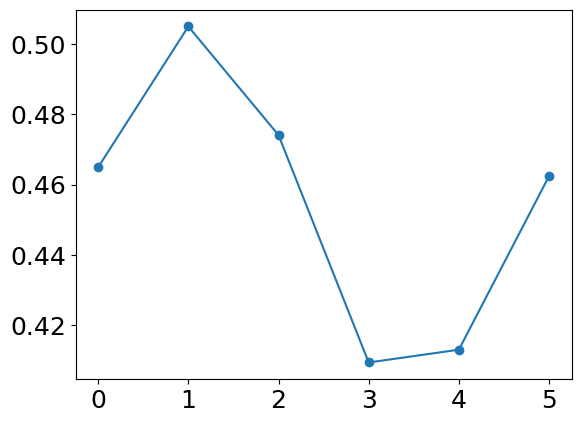

In [483]:
x = get_diff_label_list(df_test)
plt.plot(x, 'o-')
plt.savefig('../figures/label_diff_ce')
print(np.round(x, decimals=3))

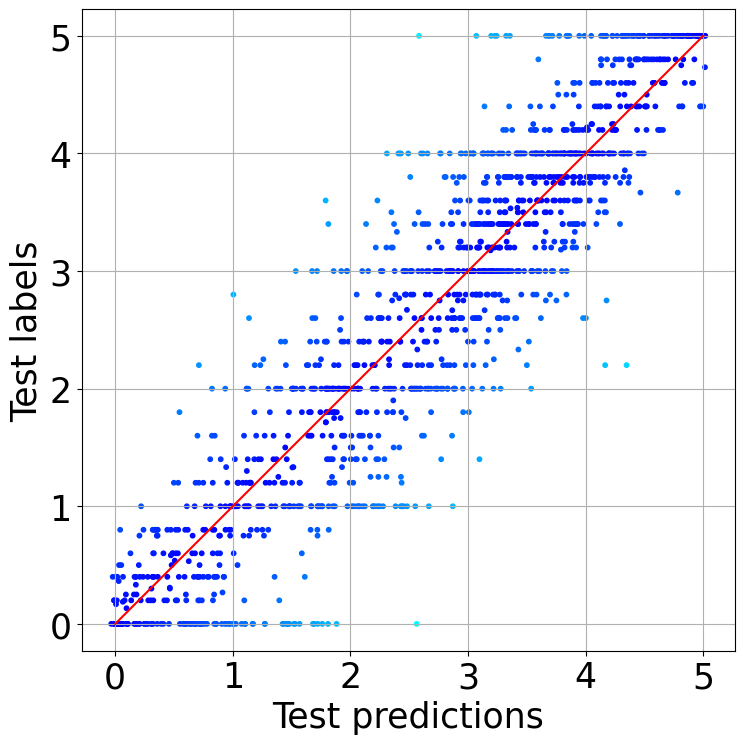

In [485]:
scatterplot_preds_labels(df_test, save='cross_entropy')

In [486]:
df_test['sent1_stopwords'] = df_test['sentence1'].apply(lambda x: len([i.lemma_ in nlp.Defaults.stop_words for i in nlp(x)]))
df_test['sent2_stopwords'] = df_test['sentence2'].apply(lambda x: len([i.lemma_ in nlp.Defaults.stop_words for i in nlp(x)]))

In [487]:
threshold = 1

df_test_severe = df_test[df_test['diff'] > threshold]
df_test_not_severe = df_test[df_test['diff'] <= threshold]

In [488]:
incorrect_ends = df_test_severe[
    (df_test_severe['label'] == 5) | (df_test_severe['label'] == 0)
][['sentence1', 'sentence2', 'label', 'preds', 'sent1_stopwords', 'sent2_stopwords', 'diff']]
incorrect_ends.head()

,sentence1,sentence2,label,preds,sent1_stopwords,sent2_stopwords,diff
770,The answer to both questions is: Yes.,To directly answer the two questions in your t...,0.0,2.563025,9,10,2.563025
745,It's also a matter of taste.,It's definitely just a matter of preference.,5.0,2.583256,8,9,2.416744
839,I had the same problem as you.,I have exactly the same problem.,5.0,3.070111,8,7,1.929889
723,You should do it.,You should prime it first.,0.0,1.882441,5,6,1.882441
630,You just have to base your answer on what you ...,"You may want it, but the process given to you ...",0.0,1.809311,19,19,1.809311


In [489]:
correct_ends = df_test_not_severe[
    (df_test_not_severe['label'] == 5) | (df_test_not_severe['label'] == 0)
][['sentence1', 'sentence2', 'label', 'preds', 'sent1_stopwords', 'sent2_stopwords', 'diff']]
correct_ends.head()

,sentence1,sentence2,label,preds,sent1_stopwords,sent2_stopwords,diff
1374,"Philippines, Canada pledge to further boost re...",Philippines saves 100 after ferry sinks,0.0,0.972835,8,6,0.972835
1378,South Korea declares end to MERS outbreak,North Korea Delegation Meets With South Korean...,0.0,0.972502,7,8,0.972502
773,Can you do this?,"So, CAN you do this?",5.0,4.047499,5,7,0.952501
725,What kind of insulation is it?,What kind of floors are above?,0.0,0.948356,7,7,0.948356
1291,"Suicide bomb kills 4, injures 13 in Pakistan",Twitter blocks content in Pakistan,0.0,0.932990,9,5,0.932990


In [490]:
incorrect_ends['lemma_perc'] = incorrect_ends.apply(
    lambda x: lemma_percentage(x), axis=1
)
incorrect_ends['lemma_perc_wo_stopword'] = incorrect_ends.apply(
    lambda x: lemma_percentage_no_stopw(x), axis=1
)

correct_ends['lemma_perc'] = correct_ends.apply(
    lambda x: lemma_percentage(x), axis=1
)
correct_ends['lemma_perc_wo_stopword'] = correct_ends.apply(
    lambda x: lemma_percentage_no_stopw(x), axis=1
)

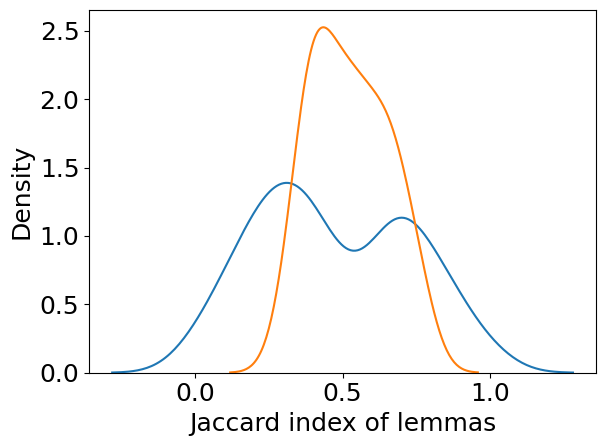

In [492]:
sns.kdeplot(correct_ends, x='lemma_perc')
sns.kdeplot(incorrect_ends, x='lemma_perc')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Jaccard index of lemmas")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_for_corr_incorr_cross_entropy.png", bbox_inches='tight')
plt.show()

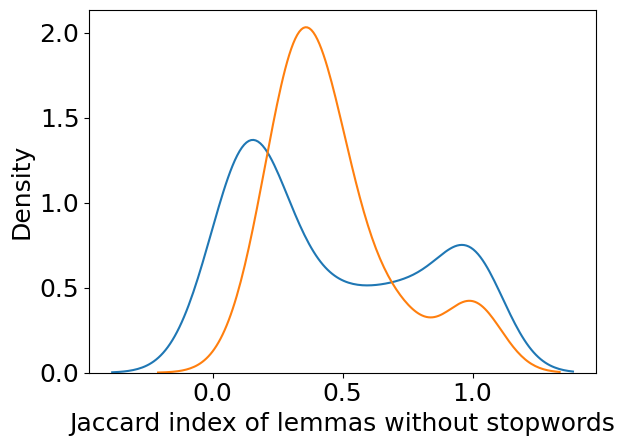

In [493]:
sns.kdeplot(correct_ends, x='lemma_perc_wo_stopword')
sns.kdeplot(incorrect_ends, x='lemma_perc_wo_stopword')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Jaccard index of lemmas without stopwords")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_wo_stopword_for_corr_incorr_cross_entropy.png", bbox_inches='tight')
plt.show()

In [494]:
incorrect_ends['lemma_perc_wo_stopword_over_sent1'] = incorrect_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence1'), axis=1
)
incorrect_ends['lemma_perc_wo_stopword_over_sent2'] = incorrect_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence2'), axis=1
)

correct_ends['lemma_perc_wo_stopword_over_sent1'] = correct_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence1'), axis=1
)
correct_ends['lemma_perc_wo_stopword_over_sent2'] = correct_ends.apply(
    lambda x: lemma_percentage_no_stopw_same(x, 'sentence2'), axis=1
)

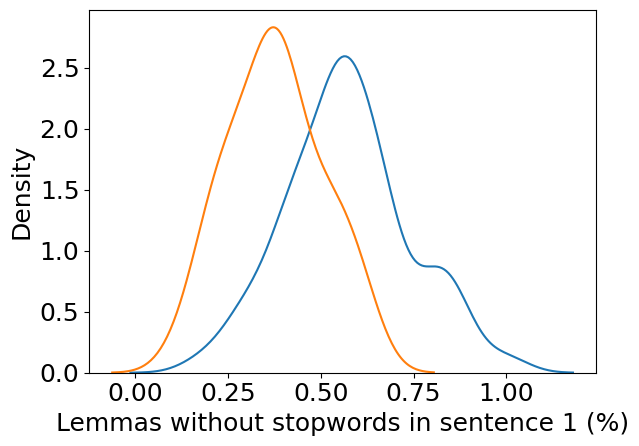

In [496]:
sns.kdeplot(correct_ends, x='lemma_perc_wo_stopword_over_sent1')
sns.kdeplot(incorrect_ends, x='lemma_perc_wo_stopword_over_sent1')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Lemmas without stopwords in sentence 1 (%)")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_wo_stopword_over_sent1_for_corr_incorr_cross_entropy.png", bbox_inches='tight')
plt.show()

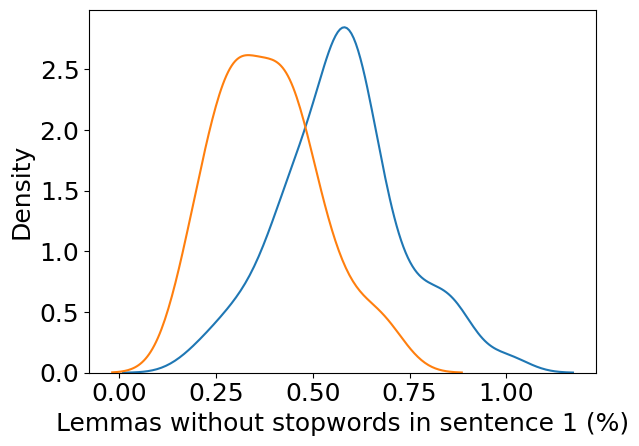

In [498]:
sns.kdeplot(correct_ends, x='lemma_perc_wo_stopword_over_sent2')
sns.kdeplot(incorrect_ends, x='lemma_perc_wo_stopword_over_sent2')
plt.rcParams.update({'font.size': 18})
plt.xlabel("Lemmas without stopwords in sentence 1 (%)")
plt.tight_layout()
plt.savefig("../figures/density_of_lemma_perc_wo_stopword_over_sent2_for_corr_incorr_cross_entropy.png", bbox_inches='tight')
plt.show()